In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import librosa
import matplotlib.pyplot as plt

# Config
DATASET_PATH = "../Voice recordings"
SAMPLE_RATE = 48000
DURATION = 1
N_MFCC = 10
BATCH_SIZE = 32
EPOCHS = 10
MODEL_SAVE_PATH = "cnn_model.keras"

In [54]:
# Load audio & extract MFCC

def load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION):
    audio, _ = librosa.load(file_path, sr=sr)
    return split_audio_into_chunks(audio, sr, duration)

def split_audio_into_chunks(audio, sr=SAMPLE_RATE, duration=DURATION):
    chunk_len = int(sr * duration)
    chunks = []

    num_chunks = int(np.ceil(len(audio) / chunk_len))

    for i in range(num_chunks):
        start = i * chunk_len
        end = start + chunk_len
        chunk = audio[start:end]

        if len(chunk) < chunk_len:
            chunk = np.pad(chunk, (0, chunk_len - len(chunk)))

        chunks.append(chunk)

    return chunks

def extract_mfcc(audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # shape: (time_steps, n_mfcc)

# -----------------------------
# Load dataset
# -----------------------------
X = []
y = []
label_map = {}
chunks_per_speaker = {}

label_id = 0
for speaker in sorted(os.listdir(DATASET_PATH)):
    speaker_path = os.path.join(DATASET_PATH, speaker, "Train")
    if not os.path.isdir(speaker_path):
        continue
    label_map[label_id] = speaker

    for file in os.listdir(speaker_path):
        if file.endswith(".wav"):
            file_path = os.path.join(speaker_path, file)
            audio_chunks = load_audio_file(file_path)
            num_chunks = len(audio_chunks)
            chunks_per_speaker[speaker] = (
                chunks_per_speaker.get(speaker, 0) + num_chunks
            )

            for audio in audio_chunks:
                mfcc = extract_mfcc(audio)
                X.append(mfcc)
                y.append(label_id)

    label_id += 1

X = np.array(X)
y = np.array(y)

# Pad/truncate to fixed time dimension
max_time_steps = max([mf.shape[0] for mf in X])
X_padded = np.zeros((len(X), max_time_steps, N_MFCC))
for i, mf in enumerate(X):
    if mf.shape[0] < max_time_steps:
        X_padded[i, :mf.shape[0], :] = mf
    else:
        X_padded[i] = mf[:max_time_steps, :]

# One-hot encode labels
y_onehot = tf.keras.utils.to_categorical(y, num_classes=len(label_map))


TOTAL CHUNKS PER SPEAKER
Lovro: 84 chunks (total: 84 seconds)


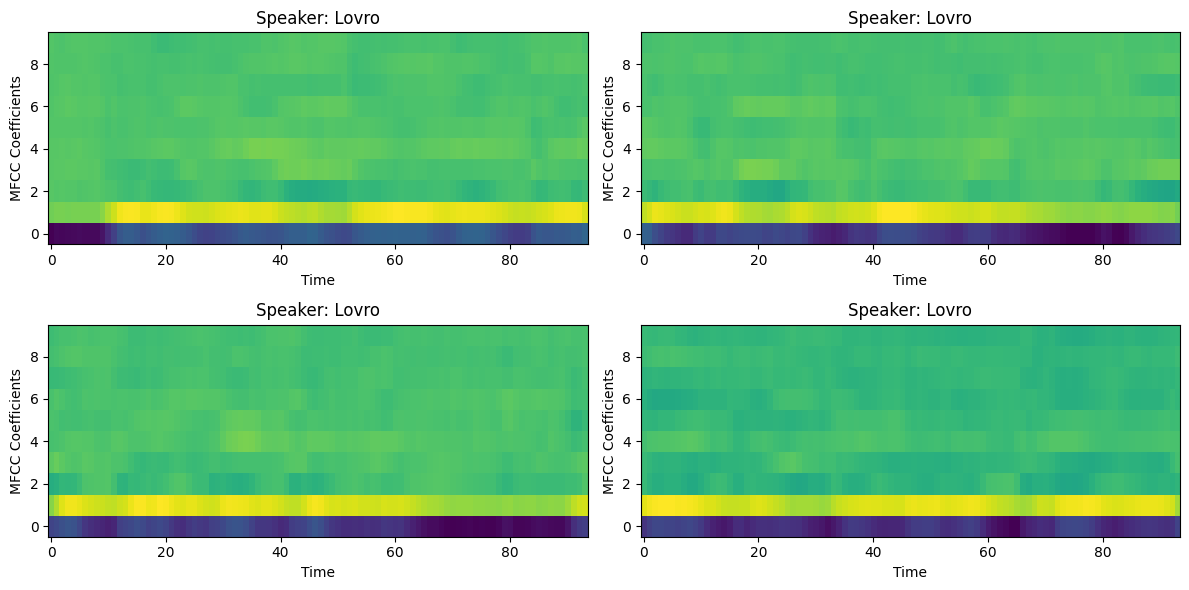

In [55]:
print("\n============================")
print("TOTAL CHUNKS PER SPEAKER")
print("============================")
for speaker, total_chunks in chunks_per_speaker.items():
    print(f"{speaker}: {total_chunks} chunks (total: {total_chunks*DURATION} seconds)")

# Visualize some MFCCs
plt.figure(figsize=(12, 6))
for i in range(min(4, len(X_padded))):
    plt.subplot(2, 2, i+1)
    plt.imshow(X_padded[i].T, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f"Speaker: {label_map[y[i]]}")
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# Build 1D-CNN model
# -----------------------------
model = models.Sequential([
    layers.Input(shape=(max_time_steps, N_MFCC)),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=3, activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),
    
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# -----------------------------
# Train the model
# -----------------------------
history = model.fit(X_padded, y_onehot, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

# -----------------------------
# Plot training history
# -----------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# -----------------------------
# Save Keras model
# -----------------------------
model.save(MODEL_SAVE_PATH)

In [ ]:
# -----------------------------
# Convert to TFLite with full integer quantization
# -----------------------------
def representative_dataset():
    for i in range(len(X_padded)):
        sample = X_padded[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_SAVE_PATH)  # ovo jos treba debuggirat
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()

# Save TFLite model
with open("speaker_cnn_model_quant.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model with quantization saved as 'speaker_cnn_model_quant.tflite'")